In [2]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import math

from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, f1_score
from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold
from sklearn.dummy import DummyClassifier

from sklearn.ensemble import RandomForestClassifier

# Libraries for pre-processing
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer

In [3]:
from numpy.core.fromnumeric import sort

# function for make the dataset to imbalanced dataset
def make_imbalance(df,output_class,percentage):
  df = df.sort_values(output_class, axis=0,ascending=True)
  x, y = df[output_class].value_counts(ascending=True)
  row = x * 100 / percentage
  return df.head(math.floor(row))

def baseline_result(data, output_class):
  x = data.drop(labels= output_class, axis=1)
  y = data[output_class]

  baseline_clf = RandomForestClassifier()
  baseline_scores = cross_val_score(baseline_clf, x, y, cv=10, scoring = 'f1')
  print("Baseline f1 score: %0.4f +/- %0.4f" % (baseline_scores.mean(), baseline_scores.std()))

In [4]:
class imbalance_dataset():
  def __init__(self, dataset):
    self.data = dataset
  
  # Plot histogram
  def hist_plot(self, width=20, height=15):
    _ = self.data.hist(bins=50, figsize=(width,height))
  # Plot heat map with linear correlation
  def heatmap(self, width=20, height=7):
    correlations = self.data.corr()
    f, ax = plt.subplots(figsize=(width, height))
    ax = sns.heatmap(correlations, annot=True, center=0,  cmap="YlGnBu")
  # Plot box plot
  def box_plot(self, width=20, height=7):
    f, ax = plt.subplots(figsize=(width, height))
    column = list(self.data.columns)
    ax = self.data.boxplot(column= column)

  def replace(self, label):
    self.data.replace(label, inplace=True)
    

In [5]:

def class_clustering(data,output_label):
  # split data to stratified 10 fold
  skf = StratifiedKFold(n_splits = 10)
  x = data.drop(labels=output_label, axis=1).values
  y = data[output_label].values

  f1score = []
  for train_index, test_index in skf.split(x, y):
    # assign parameter with 9 folds to training data and the rest is test data
    x_train = x[train_index]
    x_test = x[test_index]
    y_train = y[train_index]
    y_test = y[test_index]

    # run all trainning data to find the best number of clusters using maximun silhouette score
    inertias, sil = [], []
    for k in range(1, 12):
        kmeans = KMeans(n_clusters=k)
        y_pred = kmeans.fit_predict(x_train)
        inertias.append(kmeans.inertia_)
        if k > 1:
            sil.append(silhouette_score(x_train, y_pred))
    k = sil.index(max(sil))+2
    
    # run kmean with the best number of clusters
    kmeans = KMeans(n_clusters=k, random_state=1)
    y_kmean = kmeans.fit_predict(x_train)
    
    answer = np.zeros(len(y_test))
    for ck in range(k):                         # create the random forest classifier for each cluster from kmean
      index = np.where(y_kmean == ck)     
      y_kmean_cluster = y_train[index]          # defind real data for a cluster
      x_train_cluster = x_train[index]          # defind real data for a cluster
      random_cluster = RandomForestClassifier()
      random_cluster.fit(x_train_cluster, y_kmean_cluster)

      y_pred = kmeans.predict(x_test)           # predict the cluster from test data
      
      for i in range(len(y_pred)):              # run the random forest to identify the class in each cluster
        if y_pred[i] == ck:
          answer[i] = random_cluster.predict(np.reshape(x_test[i], (1,len(data.columns)-1)))

    f1score.append(f1_score(y_test,answer))     # save the f1 score in the list

  return f1score, k

# Cellphone dataset
https://www.kaggle.com/datasets/iabhishekofficial/mobile-price-classification

## Data Preparation

In [5]:
# loadind the data
cellphone = pd.read_csv('cellphone.csv')
cellphone.head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,...,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,...,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.5,1,2,1,41,0.9,145,5,...,1263,1716,2603,11,2,9,1,1,0,2
3,615,1,2.5,0,0,0,10,0.8,131,6,...,1216,1786,2769,16,8,11,1,0,0,2
4,1821,1,1.2,0,13,1,44,0.6,141,2,...,1208,1212,1411,8,2,15,1,1,0,1


In [6]:
# assign to class
cellphone = imbalance_dataset(cellphone)

In [7]:
cellphone.data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   battery_power  2000 non-null   int64  
 1   blue           2000 non-null   int64  
 2   clock_speed    2000 non-null   float64
 3   dual_sim       2000 non-null   int64  
 4   fc             2000 non-null   int64  
 5   four_g         2000 non-null   int64  
 6   int_memory     2000 non-null   int64  
 7   m_dep          2000 non-null   float64
 8   mobile_wt      2000 non-null   int64  
 9   n_cores        2000 non-null   int64  
 10  pc             2000 non-null   int64  
 11  px_height      2000 non-null   int64  
 12  px_width       2000 non-null   int64  
 13  ram            2000 non-null   int64  
 14  sc_h           2000 non-null   int64  
 15  sc_w           2000 non-null   int64  
 16  talk_time      2000 non-null   int64  
 17  three_g        2000 non-null   int64  
 18  touch_sc

In [8]:
cellphone.data['price_range'].value_counts()

1    500
2    500
3    500
0    500
Name: price_range, dtype: int64

In [9]:
# group the data into two classes (binary classification)
label = {'price_range':{1:0, 2:1, 3:1}}
cellphone.replace(label)
cellphone.data.head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,...,20,756,2549,9,7,19,0,0,1,0
1,1021,1,0.5,1,0,1,53,0.7,136,3,...,905,1988,2631,17,3,7,1,1,0,1
2,563,1,0.5,1,2,1,41,0.9,145,5,...,1263,1716,2603,11,2,9,1,1,0,1
3,615,1,2.5,0,0,0,10,0.8,131,6,...,1216,1786,2769,16,8,11,1,0,0,1
4,1821,1,1.2,0,13,1,44,0.6,141,2,...,1208,1212,1411,8,2,15,1,1,0,0


In [10]:
cellphone.data['price_range'].value_counts()

0    1000
1    1000
Name: price_range, dtype: int64

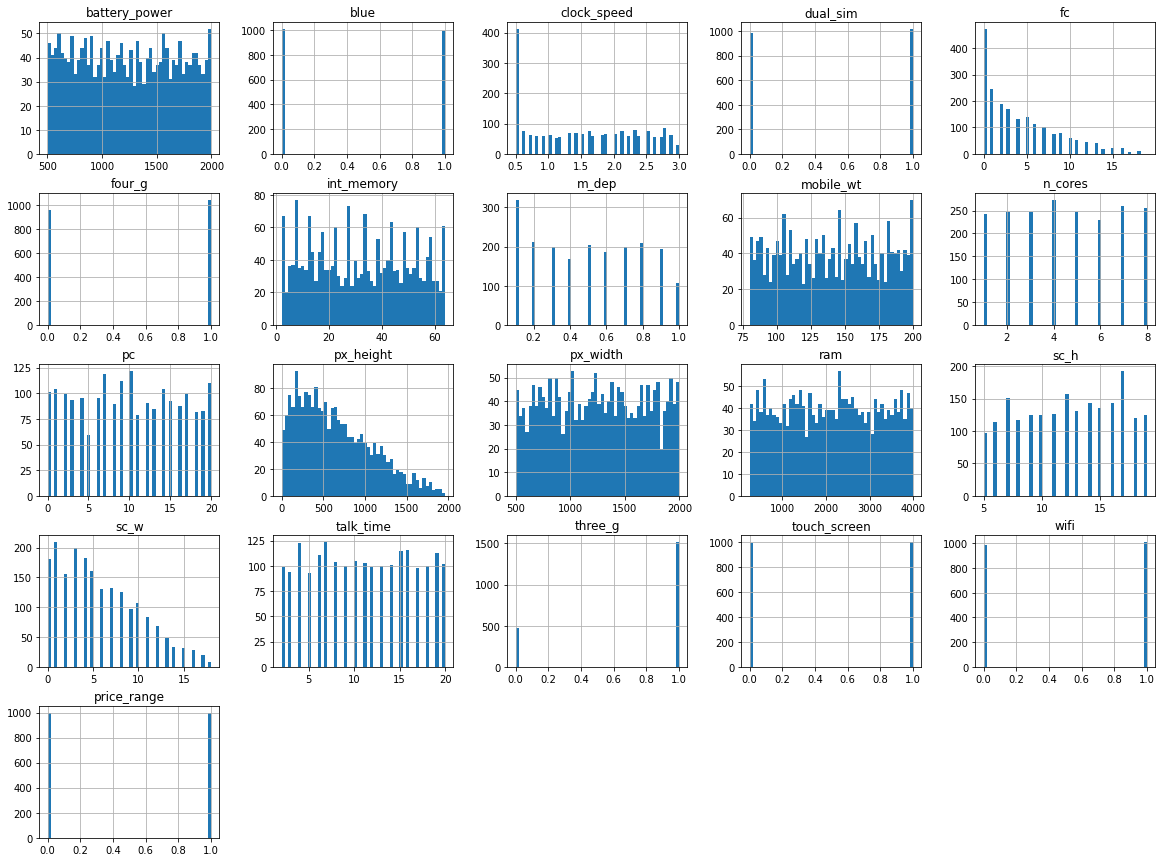

In [11]:
# plot histogram to see how the data distributed and categorical data
cellphone.hist_plot()

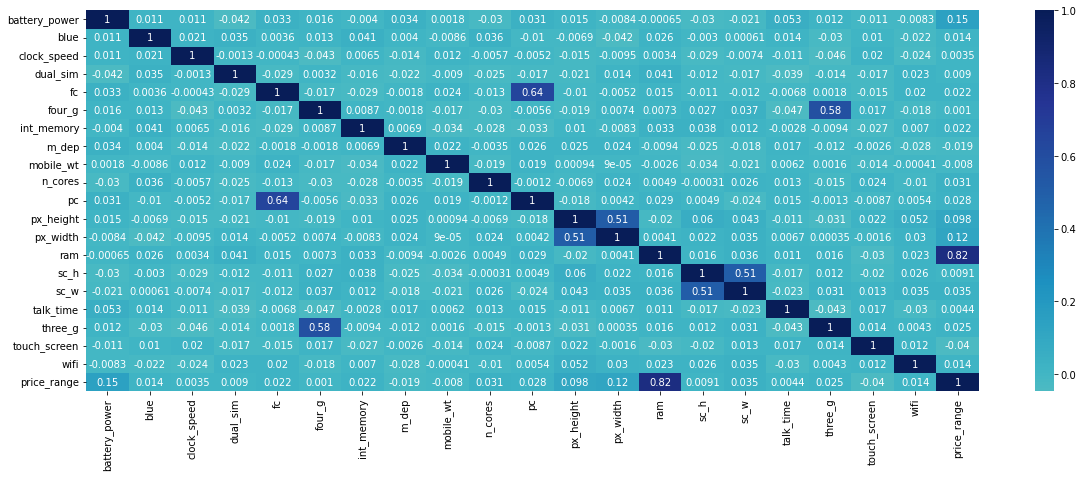

In [12]:
# Calculate the correlations between each pair of variables and plot on the heatmap
cellphone.heatmap(20,7)

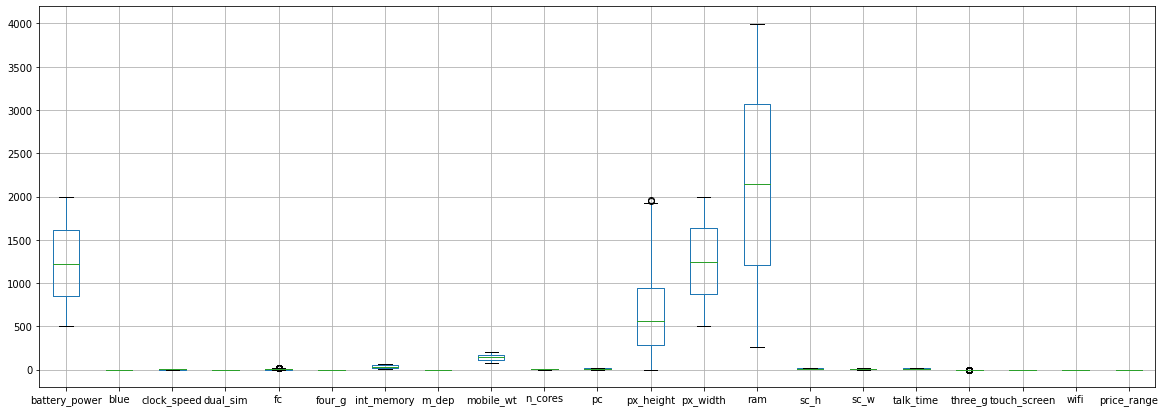

In [13]:
# plot the boxplot to see the scal of the data
cellphone.box_plot()

In [14]:
# make imbalanced dataset 65 %
mobile_data_65 = make_imbalance(cellphone.data,'price_range',65)
mobile_data_65['price_range'].value_counts()

0    1000
1     538
Name: price_range, dtype: int64

In [15]:
# make imbalanced dataset 75 %
mobile_data_75 = make_imbalance(cellphone.data,'price_range',75)
mobile_data_75['price_range'].value_counts()

0    1000
1     333
Name: price_range, dtype: int64

In [16]:
# make imbalanced dataset 90 %
mobile_data_90 = make_imbalance(cellphone.data,'price_range',90)
mobile_data_90['price_range'].value_counts()

0    1000
1     111
Name: price_range, dtype: int64

## Baseline Dummy

In [17]:
baseline_result(mobile_data_65,'price_range')

Baseline f1 score: 0.9296 +/- 0.0278


In [18]:
baseline_result(mobile_data_75,'price_range')

Baseline f1 score: 0.8924 +/- 0.0318


In [19]:
baseline_result(mobile_data_90,'price_range')

Baseline f1 score: 0.7909 +/- 0.1527


In [20]:
score, k = class_clustering(mobile_data_65,'price_range')
print("f1 score for %d clusters: %0.2f +/- %0.3f" % (k, np.mean(score), np.std(score)))

f1 score for 2 clusters: 0.93 +/- 0.022


In [21]:
score, k = class_clustering(mobile_data_75,'price_range')
print("f1 score for %d clusters: %0.2f +/- %0.3f" % (k, np.mean(score), np.std(score)))

f1 score for 2 clusters: 0.91 +/- 0.024


In [22]:
score, k = class_clustering(mobile_data_90,'price_range')
print("f1 score for %d clusters: %0.2f +/- %0.3f" % (k, np.mean(score), np.std(score)))

f1 score for 2 clusters: 0.84 +/- 0.156


# Hepatitis C Virus (HCV) dataset
https://archive.ics.uci.edu/ml/datasets/Hepatitis+C+Virus+%28HCV%29+for+Egyptian+patients

## Data Preparation

In [6]:
HCV_DATA = pd.read_csv('HCV-Egy-Data.csv')
HCV_DATA.head()

,Age,Gender,BMI,Fever,Nausea/Vomting,Headache,Diarrhea,Fatigue & generalized bone ache,Jaundice,Epigastric pain,...,ALT 36,ALT 48,ALT after 24 w,RNA Base,RNA 4,RNA 12,RNA EOT,RNA EF,Baseline histological Grading,Baselinehistological staging
0,56,1,35,2,1,1,1,2,2,2,...,5,5,5,655330,634536,288194,5,5,13,2
1,46,1,29,1,2,2,1,2,2,1,...,57,123,44,40620,538635,637056,336804,31085,4,2
2,57,1,33,2,2,2,2,1,1,1,...,5,5,5,571148,661346,5,735945,558829,4,4
3,49,2,33,1,2,1,2,1,2,1,...,48,77,33,1041941,449939,585688,744463,582301,10,3
4,59,1,32,1,1,2,1,2,2,2,...,94,90,30,660410,738756,3731527,338946,242861,11,1


In [7]:
# assign to class
HCV_DATA = imbalance_dataset(HCV_DATA)

In [8]:
HCV_DATA.data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1385 entries, 0 to 1384
Data columns (total 29 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Age                               1385 non-null   int64  
 1   Gender                            1385 non-null   int64  
 2   BMI                               1385 non-null   int64  
 3   Fever                             1385 non-null   int64  
 4   Nausea/Vomting                    1385 non-null   int64  
 5   Headache                          1385 non-null   int64  
 6   Diarrhea                          1385 non-null   int64  
 7   Fatigue & generalized bone ache   1385 non-null   int64  
 8   Jaundice                          1385 non-null   int64  
 9   Epigastric pain                   1385 non-null   int64  
 10  WBC                               1385 non-null   int64  
 11  RBC                               1385 non-null   float64
 12  HGB   

In [9]:
HCV_DATA.data['Gender'].value_counts()

1    707
2    678
Name: Gender, dtype: int64

In [28]:
# change output class into numeric data
label = {'Gender':{'Kecimen':0, 'Besni':1}}
HCV_DATA.replace(label)
HCV_DATA.data.head()

,Age,Gender,BMI,Fever,Nausea/Vomting,Headache,Diarrhea,Fatigue & generalized bone ache,Jaundice,Epigastric pain,...,ALT 36,ALT 48,ALT after 24 w,RNA Base,RNA 4,RNA 12,RNA EOT,RNA EF,Baseline histological Grading,Baselinehistological staging
0,56,1,35,2,1,1,1,2,2,2,...,5,5,5,655330,634536,288194,5,5,13,2
1,46,1,29,1,2,2,1,2,2,1,...,57,123,44,40620,538635,637056,336804,31085,4,2
2,57,1,33,2,2,2,2,1,1,1,...,5,5,5,571148,661346,5,735945,558829,4,4
3,49,2,33,1,2,1,2,1,2,1,...,48,77,33,1041941,449939,585688,744463,582301,10,3
4,59,1,32,1,1,2,1,2,2,2,...,94,90,30,660410,738756,3731527,338946,242861,11,1


In [29]:
HCV_DATA.data['Gender'].value_counts()

1    707
2    678
Name: Gender, dtype: int64

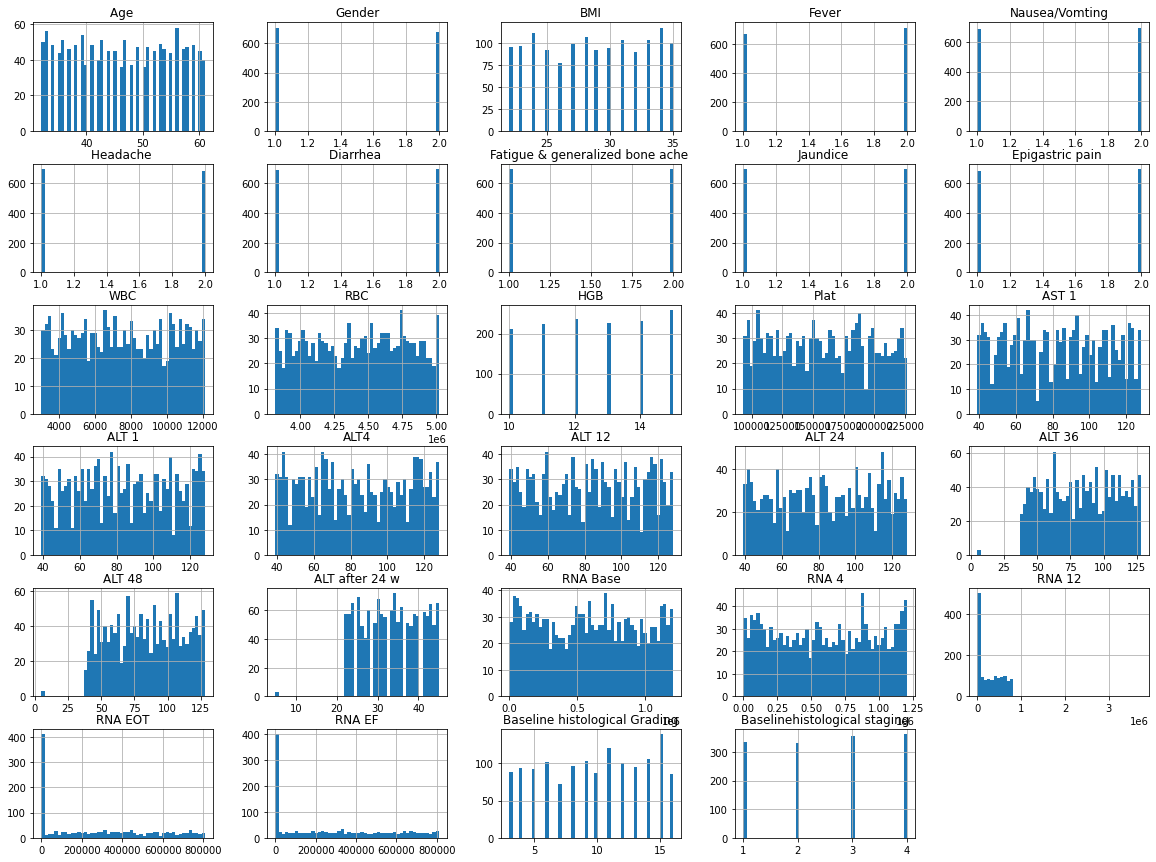

In [30]:
# plot histogram to see how the data distributed and categorical data
HCV_DATA.hist_plot()

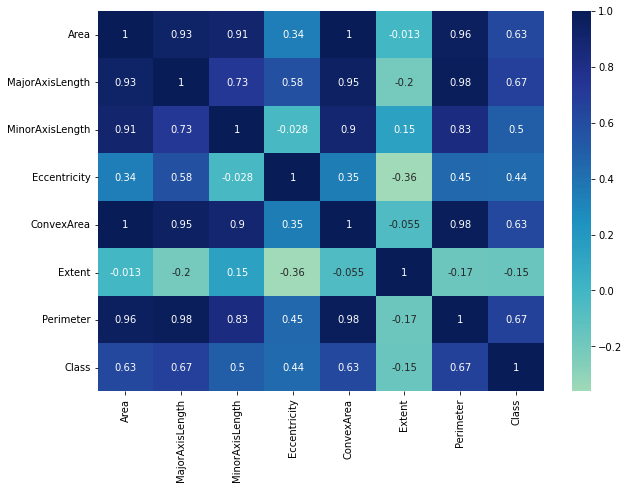

In [ ]:
# Calculate the correlations between each pair of variables and plot on the heatmap
HCV_DATA.heatmap(width=10, height=7)

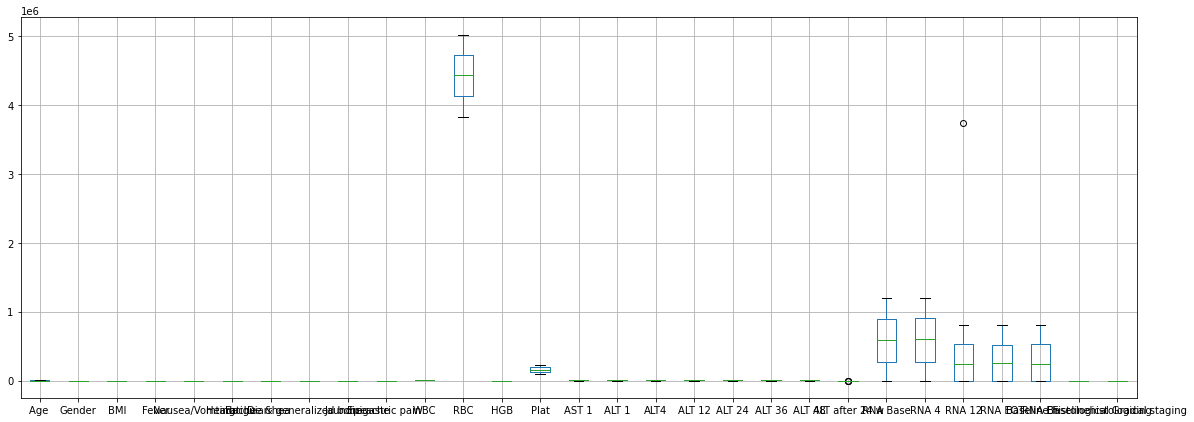

In [10]:
# plot the boxplot to see the scal of the data
HCV_DATA.box_plot()

In [11]:
# make imbalanced dataset 65 %
HCV_DATA_65 = make_imbalance(HCV_DATA.data,'Gender',65)
HCV_DATA_65['Gender'].value_counts()

1    707
2    336
Name: Gender, dtype: int64

In [12]:
# make imbalanced dataset 75 %
HCV_DATA_75 = make_imbalance(HCV_DATA.data,'Gender',75)
HCV_DATA_75['Gender'].value_counts()

1    707
2    197
Name: Gender, dtype: int64

In [13]:
# make imbalanced dataset 90 %
HCV_DATA_90 = make_imbalance(HCV_DATA.data,'Gender',90)
HCV_DATA_90['Gender'].value_counts()

1    707
2     46
Name: Gender, dtype: int64

## Baseline

In [14]:
baseline_result(HCV_DATA_65,'Gender')

Baseline f1 score: 0.8013 +/- 0.0096


In [15]:
baseline_result(HCV_DATA_75,'Gender')

Baseline f1 score: 0.8783 +/- 0.0040


In [16]:
baseline_result(HCV_DATA_90,'Gender')

Baseline f1 score: 0.9685 +/- 0.0034


In [17]:
score, k = class_clustering(HCV_DATA_65,'Gender')
print("f1 score for %d clusters: %0.2f +/- %0.3f" % (k, np.mean(score), np.std(score)))

f1 score for 10 clusters: 0.78 +/- 0.016


In [ ]:
score, k = class_clustering(HCV_DATA_75,'Gender')
print("f1 score for %d clusters: %0.2f +/- %0.3f" % (k, np.mean(score), np.std(score)))

f1 score for 2 clusters: 0.75 +/- 0.088


In [ ]:
score, k = class_clustering(HCV_DATA_90,'Gender')
print("f1 score for %d clusters: %0.2f +/- %0.3f" % (k, np.mean(score), np.std(score)))

f1 score for 2 clusters: 0.79 +/- 0.104


# Wine Quality dataset
https://www.kaggle.com/datasets/yasserh/wine-quality-dataset

## Data Preparation

In [40]:
wine_data = pd.read_csv('Wine.csv')
wine_data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,Id
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,1
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,2
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,3
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,4


In [41]:
wine_data = imbalance_dataset(wine_data)

In [42]:
wine_data.data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1143 entries, 0 to 1142
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1143 non-null   float64
 1   volatile acidity      1143 non-null   float64
 2   citric acid           1143 non-null   float64
 3   residual sugar        1143 non-null   float64
 4   chlorides             1143 non-null   float64
 5   free sulfur dioxide   1143 non-null   float64
 6   total sulfur dioxide  1143 non-null   float64
 7   density               1143 non-null   float64
 8   pH                    1143 non-null   float64
 9   sulphates             1143 non-null   float64
 10  alcohol               1143 non-null   float64
 11  quality               1143 non-null   int64  
 12  Id                    1143 non-null   int64  
dtypes: float64(11), int64(2)
memory usage: 116.2 KB


In [43]:
# drop not relevant feature 'Id' and check values in output column
wine_data.data.drop(columns = 'Id', inplace=True)
wine_data.data['quality'].value_counts()

5    483
6    462
7    143
4     33
8     16
3      6
Name: quality, dtype: int64

In [44]:
label = {'quality':{3:0, 4:0, 5:0, 6:1, 7:1, 8:1}}
wine_data.replace(label)
wine_data.data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,1
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0


In [45]:
wine_data.data['quality'].value_counts()

1    621
0    522
Name: quality, dtype: int64

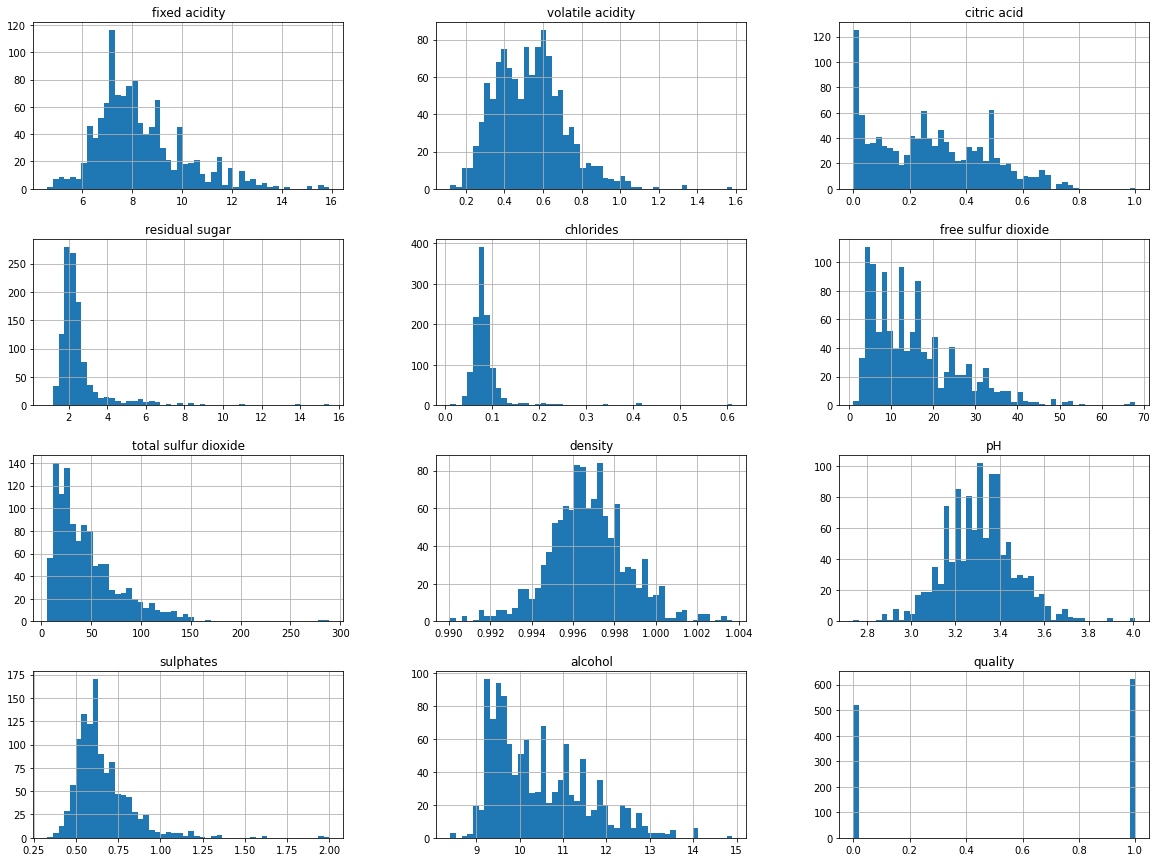

In [46]:
# plot histogram to see how the data distributed and categorical data
wine_data.hist_plot()

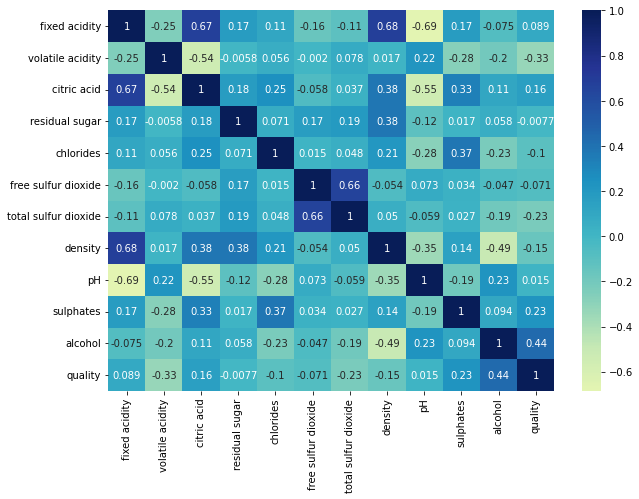

In [47]:
# Calculate the correlations between each pair of variables and plot on the heatmap
wine_data.heatmap(width=10,height=7)

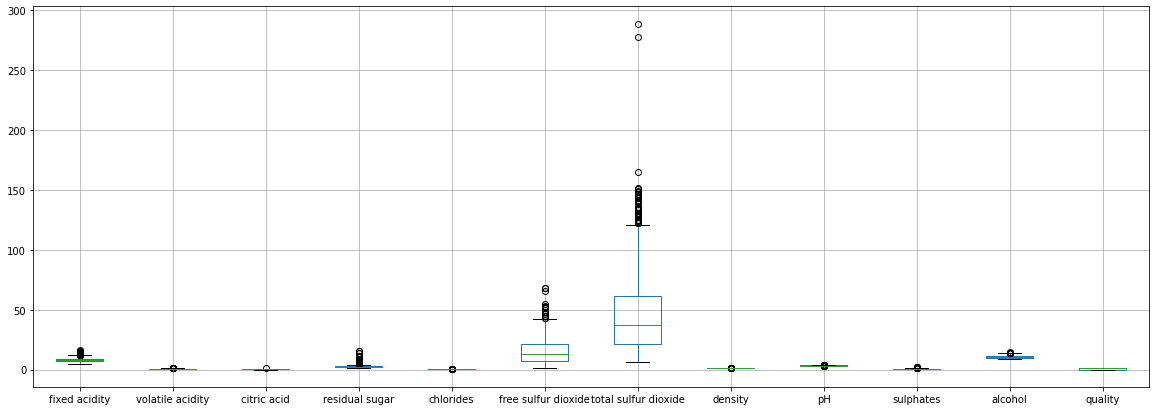

In [48]:
# plot the boxplot to see the scal of the data
wine_data.box_plot()

In [49]:
# make imbalanced dataset 65 %
wine_data_65 = make_imbalance(wine_data.data,'quality',65)
wine_data_65['quality'].value_counts()

0    522
1    281
Name: quality, dtype: int64

In [50]:
# make imbalanced dataset 75 %
wine_data_75 = make_imbalance(wine_data.data,'quality',75)
wine_data_75['quality'].value_counts()

0    522
1    174
Name: quality, dtype: int64

In [51]:
# make imbalanced dataset 90 %
wine_data_90 = make_imbalance(wine_data.data,'quality',90)
wine_data_90['quality'].value_counts()

0    522
1     58
Name: quality, dtype: int64

## Baseline

In [52]:
baseline_result(wine_data_65,'quality')

Baseline f1 score: 0.6326 +/- 0.1246


In [53]:
baseline_result(wine_data_75,'quality')

Baseline f1 score: 0.5977 +/- 0.1116


In [54]:
baseline_result(wine_data_90,'quality')

Baseline f1 score: 0.4641 +/- 0.2976


In [55]:
score, k = class_clustering(wine_data_65,'quality')
print("f1 score for %d clusters: %0.2f +/- %0.3f" % (k, np.mean(score), np.std(score)))

f1 score for 2 clusters: 0.62 +/- 0.138


In [ ]:
score, k = class_clustering(wine_data_75,'quality')
print("f1 score for %d clusters: %0.2f +/- %0.3f" % (k, np.mean(score), np.std(score)))

f1 score for 2 clusters: 0.58 +/- 0.093


In [ ]:
score, k = class_clustering(wine_data_90,'quality')
print("f1 score for %d clusters: %0.2f +/- %0.3f" % (k, np.mean(score), np.std(score)))

f1 score for 2 clusters: 0.44 +/- 0.272
